   # Quantifying ranking bias
   ### A quick example on a synthetic network
   
   We have recently developed a statistical framework to quantify biases of(in) rankings [1]. Our framework is based on two simple ideas: first, we define an unbiased selection process, and then we use the Mahalanobis distance [2] to compare the observed rankings against what is expected from the unbiased selection process.  To present this framework and provide an intuition on how it works, we here provide a tutorial. 
   
  We initially grow a synthetic network using the linear preferential attachment rule [3]. This rule is choosen as it is one of the simplest rules that causes the final degree of the nodes to be strongly correlated with their age: the older the node, the higher the degree (the age of a node is defined based on the time at which the node entered into the network). Afterwards, we rank the nodes according to their degree and PageRank score, and use our framework to show that the top-10% of these rankings is biased by the age of the nodes.
   
   1. G. Vaccario, M. Medo, N. Wider, M.S. Mariani: **Quantifying and suppressing ranking bias in a large citation network** [[1703.08071]](https://arxiv.org/abs/1703.08071)
   2. [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)
   3. [Barabasi-Albert model](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model)

In [1]:
import numpy as np
import igraph
import matplotlib
import matplotlib.pyplot as plt

from quantbias import *
from mhd import *
from IPython.display import * 
from IPython.display import HTML                             

### The synthetic network

We grow a directed scale-free network using the functions pre-defined by igraph.
In particular, we use the linear preferential attachment rule as growing mechanism.

In [2]:
no_of_nodes = 1000
no_of_links = 4
cit_net = igraph.Graph.Barabasi(no_of_nodes,no_of_links,outpref=False,directed=True, power=1, zero_appeal = 1)
igraph.summary(cit_net)

IGRAPH D--- 1000 3990 -- 


To visualize the network we use various plotting features of igraph.
First, we use the Fruchterman-Reingold layout for the visualization of the network. 

In [3]:
layout = cit_net.layout('fr')

We scale the size of the nodes accordingly to their IN-degree

In [4]:
visual_style={}
visual_style["vertex_size"]=[4 + 2*np.log(i+1) for i in cit_net.degree(mode = "IN")]

and color the nodes from light (older nodes) to dark (younger nodes) purple.

In [5]:
visual_style["vertex_color"]=[]
min_light = 0.2
palette = [plt.cm.Purples]
for i in range(no_of_nodes):
    color = palette[0](min_light + (i-min_light)/no_of_nodes)#older nodes lighter color
    visual_style["vertex_color"].append("rgb"+str(tuple(x*255 for x in color[:3])))       

Finally, we make the edges thin in order to make the image of the network more presentable.

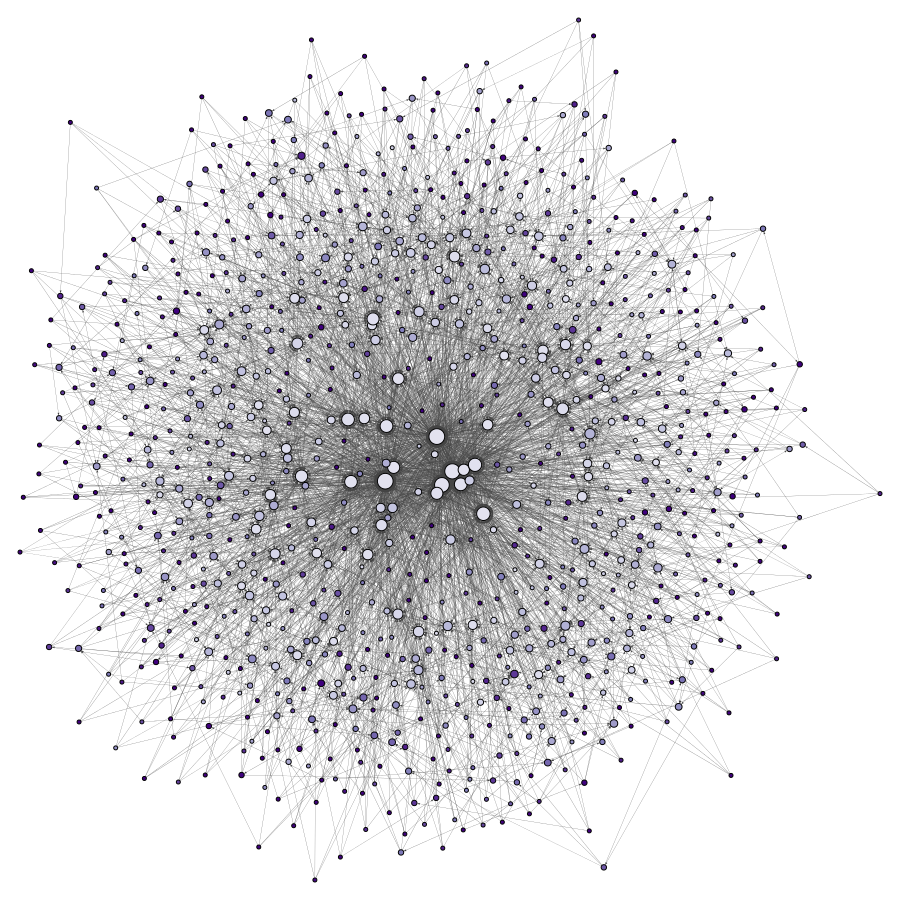

In [6]:
visual_style["edge_width"]=0.2
visual_style["edge_arrow_size"] = 0.2
visual_style["bbox"] = (900, 900)
visual_style["layout"]=layout
filename="temp"+'.png'
igraph.plot(cit_net,filename, **visual_style)
display(Image(filename=filename))

We compute various rankings on this synthetic network and test for their bias by node age. From the mechanism used to grow the network, we already know that old nodes - the ones that entered the network at the beginning - have on average higher degree than recent nodes.

We can show the indegree's bias by dividing the nodes into $F=10$ age groups of equal size. Then, we check the age groups to which the top $10\%$ of the nodes by degree or PageRank belong to. Since our framework can be applied to any ranking bias and it is not limited to the bias by node age, we generically refer to the age groups as *"categories"*. For the same reason, for a given ranking, we refer to the vector that contains the number of nodes in the top $10\%$ from the $F$ categories as *ranking vector*.

In [7]:
#Number of categories
F=10
#Vector containing the *number* of publications in each category
#for this example we assume equal categorie size
m=[int(no_of_nodes/F) for i in range(F) ]
#Top-z% that we wish to sample
percentage = 10
#Total number of publication (with repetition)
N=sum(m)
#Number of publication belonging to the top-z%
no_of_publication_to_draw = int(np.floor(percentage*N)/100)

In [8]:
#Then, we obtain the degree sequence and the PageRank scores from the network
obs_Cit = cit_net.degree(mode = "IN")
obs_PageRagnk = cit_net.pagerank(directed = "True")
#We rank our papers/nodes according to their degree and PageRank
CIT_ranking = np.argsort(-np.array(obs_Cit))
PGR_ranking = np.argsort(-np.array(obs_PageRagnk))
#We keep only the top-z% of the ranking
top_CIT_rank = CIT_ranking[:no_of_publication_to_draw]
top_PGR_rank = PGR_ranking[:no_of_publication_to_draw]

In [9]:
#Create a dictionary where each entry is a paper/node with its category
#OBS. If the paper/nodes belongs to more than one category, we should assign a list
pub_category = {}
cat=0
count=0
for i in range(no_of_nodes):
    if count>=int(no_of_nodes/F):
        cat+=1
        count=0
    pub_category[i] = cat
    count+=1
#Creating the ranking vectors, 
#i.e. the vector containing the number of papers/nodes belonging to each categeory in the top-z%
CIT_rank_vect = [0 for i in range(F)]
for node in top_CIT_rank:
    CIT_rank_vect[pub_category[node]]+=1
PGR_rank_vect = [0 for i in range(F)]
for node in top_PGR_rank:
    PGR_rank_vect[pub_category[node]]+=1

In [10]:
CIT_rank_vect

[56, 30, 13, 1, 0, 0, 0, 0, 0, 0]

We can see that most of the nodes that belong to the first category,
i.e. the oldest nodes, are the ones that have the highest degree, while younger nodes have a much smaller degree.
A similar observations holds for the PageRank scores.

In [11]:
PGR_rank_vect

[61, 29, 10, 0, 0, 0, 0, 0, 0, 0]

How do we assess the magnitude of this bias towards old nodes?
We quantify the systematic deviation from some expected values.
In the following, we introduce a null model which enables to define the **expected unbiased values** as well as a **unbiased selection process** to evaluate whether the observed deviations from these expected values are statistically significant or not.

### The Null Model
The null model [1] is defined through the following steps:
    1. color each node according to the category to which it belongs
    2. put the nodes in a urn
    3. randomly extract n nodes from the urn without replacement
    4. count the number of sampled nodes of each different color/category
This simulates an *unbiased* selection process with respect to the colors of the nodes because the colors play no role during the sampling. 
The number of extracted nodes of each color follows a multivariate hypergeometric distribution (MHD).

The expected number of extracted nods of color $i$ is $\mu_i=n K_i/N$, where $N$ is the total number of nodes in the urn, $K_i$ is the total number of nodes that belong to category $i$ and $n$ is the number of extracted nodes. In our example, we have $N=1000$ (the size of the network), $K_i=100=N/F$ for $i=1,\dots,F$ (the categories are equally-sized), and $n=100=0.1\,N$ nodes belonging to the top-$10\%$ of the ranking. Hence, the expected vector is

In [12]:
multivariate_hypergeometric_expected_vector(no_of_publication_to_draw, m)

array([ 10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.])

We can also simulate the process described in the four steps above and then check which kind of ranking vectors this procedure creates. Here is one exemplary ranking vector:

In [13]:
multivariate_hypergeometric_sampling(no_of_publication_to_draw, m, simul=1)

[array([ 9, 10, 14,  8, 10, 11,  4, 10, 12, 12])]

This vectore is different from the expected unbiased vector. But since it is created using the unbiased sampling procedure, we should not consider it biased, even though there are categories which are over-represented and other that are under-represented.
How can we quantify the statistical significance of the differences between this vector and the expected unbiased vector? Likewise, how can we do the same for the expected unbiased vector and the ranking vectors by indegree and PageRank?

### The Mahalanobis Distance
The Mahalanobis Distance, $d_{\mathcal{M}}$, is a standard measure used in statistics that permits to quantify the difference between an observation and a distribution. Specifically, if we observe a vector $\mathbf{x}^{T}=(x_1, \dots,x_F)$, its Mahalanobis distance $d_{\mathcal{M}}$ from a set of observations with mean $\vec{\mu}^{T}=(\mu_1, \dots ,\mu_F)$ is  

\begin{equation}
d_{\mathcal{M}}(\vec{x},\vec{\mu})=\sqrt{(\vec{x}-\vec{\mu})^{T} S^{-1}(\vec{x}-\vec{\mu})}
\end{equation}

where $S^{-1}$ is the inverse of the covariance matrix.
To get an intuition of this definition, let's first consider the case of *uncorrelated* observations For this particular case, the covariance matrix $S$ is diagonal: $S=diag(\sigma_1^2,\dots,\sigma_F^2)$ where $\sigma_i^2$ is the variance of the distribution of the $i$th variable. The Mahalanobis distance $d_\mathcal{M}$ is thus given by 

\begin{equation}
d_{\mathcal{M}}(\vec{x},\vec{\mu})=\sqrt{ \sum_i^F \left(\frac{  {x_i}-\mu_i}{\sigma_i} \right)^2 } =\sqrt{\sum_i^F{ z_i^2}}
\end{equation}

where $ z_i =\frac{  {x_i}-\mu_i}{\sigma_i}$ is the standard score for the observation $x_i$. Intuitively, the standard score quantifies how much the observation $x_i$ deviates from the expected value $\mu_i$ in units of $\sigma_i$. The Mahalanobis Distance generalizes the notion of standard score to the general case of correlated variables.

We have shown above that the covariance matrix coming from the MHD is not diagonal, so we cannot use the simplified equation for uncorrelated variables. 
However, we have obtained a simular formula for the MHD case:

\begin{equation}
d_{\mathcal{M}}(\vec{x},\vec{\mu}) = \sqrt{ \sum_i^F \left(\frac{  {x_i}-\mu_i}{\sigma_i} \right)^2 \left(1 - \frac{K_i}{N}\right)}
\end{equation}

Its analytic derivation in three dimension is given in Appendix B of [1]. 
Now, we compute the $d_\mathcal{M}$ for the ranking vectors obtained from the unbiased sampling process described above.

In [14]:
simul = 10000
sampling = multivariate_hypergeometric_sampling(no_of_publication_to_draw, m, simul=10000) 

In [15]:
print("Calulating the MD for the sampled vectors obtained with the unbiased selection process")
print("Using explicit formula for the multivariate hypergeometric distribution")
sampled_MD_F1 = []
mu = multivariate_hypergeometric_expected_vector(no_of_publication_to_draw, m)
for x in sampling:
    sampled_MD_F1.append(multivariate_hypergeometric_Mahalanobis_distance(x,
                                                                         mu,
                                                                         m)[0]
                      )

Calulating the MD for the sampled vectors obtained with the unbiased selection process
Using explicit formula for the multivariate hypergeometric distribution


In [16]:
print("Calulating the MD for the sampled vectors obtained with the unbiased selection process")
print("Using general formula for the multivariate hypergeometric distribution")
sampled_MD_F2 = []
mu = multivariate_hypergeometric_expected_vector(no_of_publication_to_draw, m)
cov_mat = multivariate_hypergeometric_covariance_matrix(no_of_publication_to_draw, m)
inv_cov = np.linalg.inv(cov_mat)
for x in sampling:
    sampled_MD_F2.append(Mahalanobis_distance(x[:-1],# we have to remove the last component
                                            mu[:-1],# we have to remove the last component
                                            inv_cov)
                      )

Calulating the MD for the sampled vectors obtained with the unbiased selection process
Using general formula for the multivariate hypergeometric distribution


These two formulas give $d_\mathcal{M}$ values for each sampled vector that are identical to more than 10 decimal digits, thereby confirming that validity of our analytic result.

In [17]:
sum(np.abs(np.array(sampled_MD_F1)-sampled_MD_F2))

4.4090286976938842e-12

Also *numpy.allclose()* returns a positive result:

In [18]:
np.allclose(sampled_MD_F1,sampled_MD_F2)

True

### Comparing the observerd rankings with the unbiased selection process

We now calculate the $d_{\mathcal{M}}$ of the ranking vectors coming from indegree and PageRank for the our synthetic network.
Then, we compare their $d_{\mathcal{M}}$s with the ones coming from the simulations in order to detect and quantify possible biases.

In [19]:
md_CIT, md_CIT_vect = multivariate_hypergeometric_Mahalanobis_distance(CIT_rank_vect, mu, m)
md_PGR, md_PGR_vect = multivariate_hypergeometric_Mahalanobis_distance(PGR_rank_vect, mu, m)

In [20]:
print("The Mahalanobis Distance of the top",percentage,"% ranking created using Indegree, i.e. citation count is")
print(np.round(md_CIT, decimals=2))
p_CIT = -np.sort(-md_CIT_vect)[0]/md_CIT/md_CIT*100
p_cat_CIT = np.argsort(-md_CIT_vect)[0]
print(np.round(p_CIT, decimals=1),"% of the bias can be explained by the category number", p_cat_CIT)

The Mahalanobis Distance of the top 10 % ranking created using Indegree, i.e. citation count is
18.86
66.0 % of the bias can be explained by the category number 0


In [21]:
print("The Mahalanobis Distance of the top",percentage,"% ranking created using PageRank is")
print(np.round(md_PGR, decimals=2))
p_PGR = -np.sort(-md_PGR_vect)[0]/md_CIT/md_CIT*100
p_cat_PGR = np.argsort(-md_PGR_vect)[0]
print(np.round(p_PGR, decimals=1),"% of the bias can be explained by the category number", p_cat_PGR)

The Mahalanobis Distance of the top 10 % ranking created using PageRank is
20.16
81.1 % of the bias can be explained by the category number 0


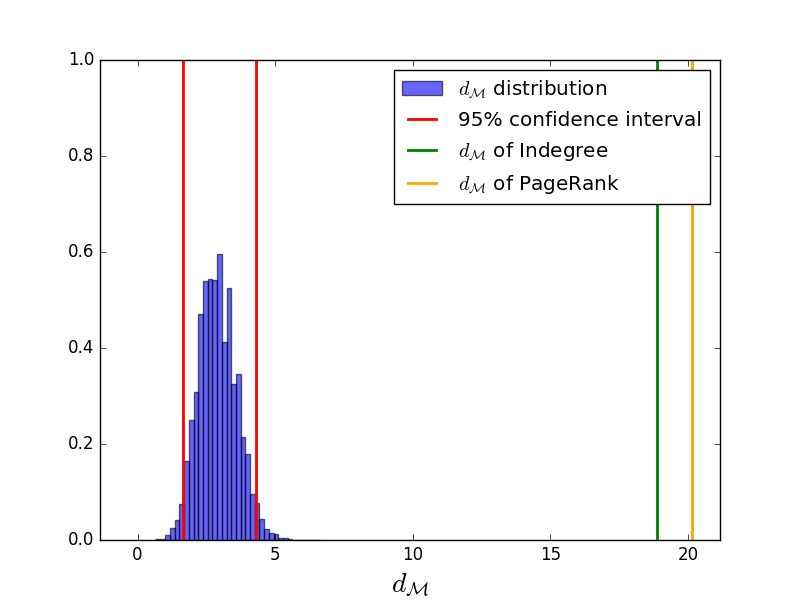

In [22]:
plt.hist(sampled_MD_F2, bins=35, normed=True, alpha=0.6, color = 'b', label = "$d_\mathcal{M}$ distribution")
upper_b = np.sort(sampled_MD_F2)[int(97.5*simul/100)]
lower_b = np.sort(sampled_MD_F2)[int(2.5*simul/100)]
plt.vlines(upper_b, 0 ,1, lw=2, color='r', label="95% confidence interval")
plt.vlines(lower_b, 0 ,1, lw=2, color='r')
plt.vlines(md_CIT, 0 , 1, lw=2, color ="g", label="$d_\mathcal{M}$ of Indegree")
plt.vlines(md_PGR, 0 , 1, lw=2, color ="orange", label="$d_\mathcal{M}$ of PageRank")
plt.xlim(lower_b-3,max(md_PGR,md_CIT,upper_b)+1)
plt.xlabel('$d_\mathcal{M}$', fontsize=20)
plt.legend()
filename = 'MD_dist.png'
plt.savefig(filename)
plt.close()
display(Image(filename=filename))

In this example, we find that both rankings are extremely biased because their $d_\mathcal{M}$s are more than 4 times bigger than the upper bound of a confidence interval containg 95% of the simulated unbiased rankings. This means that if we represent the ranking vectors as points in a multidimensional space, the two points corresponding to the rankings vectors by indegree and PageRank are far away from the cloud of points that represent the sampled vetors. To visualize this in the $F$ dimensional space is not easy when $F>3$, but we can make a representative plot by considering only two categories. 

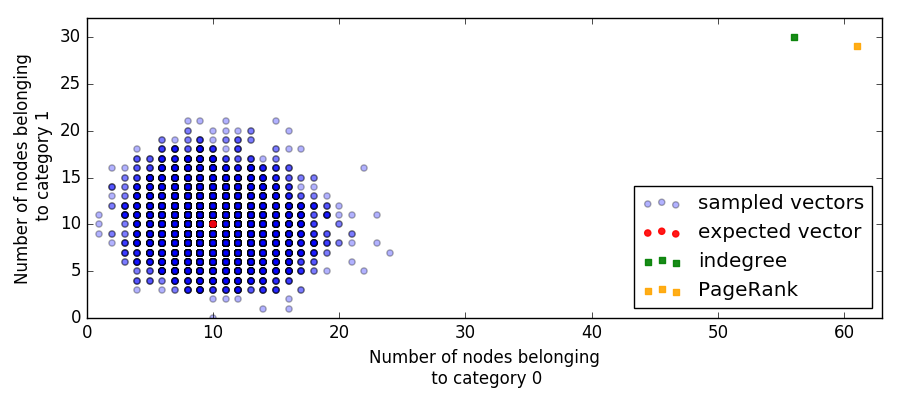

In [23]:
#We choose the two categories
dim_x = 0 #x-axis
dim_y = 1 #y-axis
#Obtaining the x and y coordinates for the sampled vectors
x_sampled = [v[dim_x] for v in sampling]
y_sampled = [v[dim_y] for v in sampling]
#Obtaining the x and y coordinates for the rankings
x_CIT = CIT_rank_vect[dim_x]
y_CIT = CIT_rank_vect[dim_y]
x_PGR = PGR_rank_vect[dim_x]
y_PGR = PGR_rank_vect[dim_y]
#Creating the scatter plot
plt.clf()
fig = plt.figure(figsize=(9,4))
plt.xlim(0,max(x_CIT, x_PGR, max(x_sampled))+2)
plt.xlabel("Number of nodes belonging\n to category "+str(dim_x))
plt.ylabel("Number of nodes belonging\n to category "+str(dim_y))
plt.ylim(0,max(y_CIT, y_PGR, max(y_sampled))+2)
plt.scatter(x_sampled,y_sampled, alpha = 0.3, label = "sampled vectors")
plt.scatter(mu[dim_x],mu[dim_y], alpha = 0.9, color = 'red', label = "expected vector")
plt.scatter(x_CIT,y_CIT, alpha=0.9, marker='s', color= 'green', label = "indegree")
plt.scatter(x_PGR,y_PGR, alpha=0.9, marker='s', color= 'orange', label = "PageRank")
plt.legend(loc="lower right")
plt.tight_layout()
filename = "scatter_2d_proj.png"
plt.savefig(filename)
plt.close()
display(Image(filename=filename))

To summarize, we find that there is almost no chance that the top of the rankings created with indegree and PageRank were obtained using the unbiased selection process defined above. 
Therefore, we have to accept the hypothesis that the rankings by indegree and PageRank are biased by the age of the nodes.

As final remark, let us remind that we have considered $F$ categories corresponding to the *age of the nodes* as we have investigated the *age bias* of rankings. However, we could have grouped the nodes in a different way to investigate a different bias. For example, in a citation network where each node represents a paper and a link a citation, we could divide the nodes according to their *scientific field* and study the *field bias* of rankings of papers using the same procedure that we have just presented. We have carried out this analysis in [1].